TODO: 
- use linear models but before deal with skewness and outliers in preprocessing
- what metrics & why?
- which models overfit and what to do
- SHAP


![](./img/robert-ritchie-JEicDFy5Cd8-unsplash_Copy.jpg)

Photo by <a href="https://unsplash.com/@robert___ritchie?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Robert Ritchie</a> on <a href="https://unsplash.com/fr/photos/JEicDFy5Cd8?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  


# Datasets & Problem Statement


Those datasets come form the [open data platform provided by the city of Seattle](https://data.seattle.gov/). Seattle’s Building Energy Benchmarking and Reporting Program requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings.  

In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.

The records for the years from 2015 to 2020 are available except 2018.

Here i'm going to:
- first in part 1, analyze all the informatins over the differents years.
- then in the 2nd part, prepare the dataset for a specific year in order to make a prediction model of the total GHG emissions depending on the buildings' characteristics.

This is the second part.

here

In [72]:
import numpy as np
import pandas as pd
from scipy.stats import loguniform

import pickle

import plotly.express as px
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, FunctionTransformer


from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR

import lightgbm as lgb
import shap

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)


df = pd.read_csv("./data/clean/2016_clean_dataset.csv", sep=";")
print(df.shape)
df.head()

(3353, 38)


,OSEBuildingID,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ComplianceStatus,Outlier,ZipCode,Latitude,Longitude,NbProperty,BuildingAge
0,1,NonResidential,hotel_catering -,7,downtown,1,12,88434,0.0,88434.0,hotel_catering -,hotel_catering -,88434.0,none,0.0,none,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,2.83,Compliant,NaN,98101,47.61220,-122.33799,1,89
1,2,NonResidential,hotel_catering -,7,downtown,1,11,103566,15064.0,88502.0,hotel_catering -,hotel_catering -,83880.0,none,15064.0,hotel_catering -,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,2.86,Compliant,NaN,98101,47.61317,-122.33393,3,20
2,3,NonResidential,hotel_catering -,7,downtown,1,41,956110,196718.0,759392.0,hotel_catering -,hotel_catering -,756493.0,none,0.0,none,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,2089.28,2.19,Compliant,NaN,98101,47.61393,-122.33810,1,47
3,5,NonResidential,hotel_catering -,7,downtown,1,10,61320,0.0,61320.0,hotel_catering -,hotel_catering -,61320.0,none,0.0,none,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,286.43,4.67,Compliant,NaN,98101,47.61412,-122.33664,1,90
4,8,NonResidential,hotel_catering -,7,downtown,1,18,175580,62000.0,113580.0,hotel_catering - leisure -,hotel_catering -,123445.0,none,68009.0,leisure -,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,505.01,2.88,Compliant,NaN,98121,47.61375,-122.34047,3,36


---

# Feature Engineering

homosedasticity!!!!!!!!

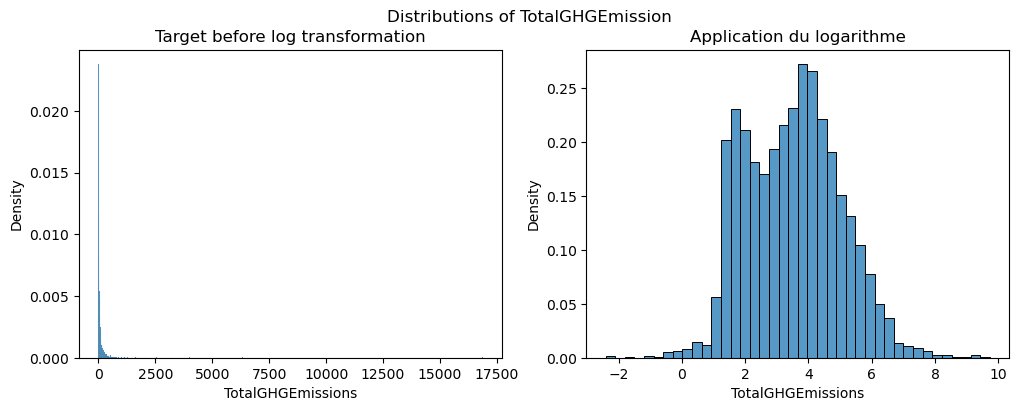

In [79]:
logtransformer = FunctionTransformer(np.log, inverse_func=np.exp, check_inverse=True)

y = df[['TotalGHGEmissions']]

y_log = logtransformer.transform(y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12, 4))

sns.histplot(data=y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Target before log transform")

sns.histplot(data=y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Target after log transform")
plt.suptitle("Distributions of TotalGHGEmission", fontsize=12)

plt.show()

We could also have used [PolynomialFeatures of scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) to generate polynomial and interaction features. But let's stick with that for the moment. We don't have so much data, so this is not a good idea to add too many freedom degrees. (Eventhough, the various features selection could help for that.)

In [11]:
df = df.assign(
    RateParking = round(df.PropertyGFAParking / df.PropertyGFATotal, 4),
    RateBuilding = round(df['PropertyGFABuilding(s)'] / df.PropertyGFATotal, 4),
    RatePerFloors = round(df.PropertyGFATotal / df.NumberofFloors, 4),
    RatePerBuildings = round(df.PropertyGFATotal / df.NumberofBuildings, 4),
    RateLargestPropertyUseType = round(df.LargestPropertyUseTypeGFA / df.PropertyGFATotal, 4),
    RateSecondLargestPropertyUseType = round(df.SecondLargestPropertyUseTypeGFA / df.PropertyGFATotal, 4),
    RateThirstLargestPropertyUseType = round(df.ThirdLargestPropertyUseTypeGFA / df.PropertyGFATotal, 4),
    NumberOfAllUseTypes = df.ListOfAllPropertyUseTypes.str.count(" - ") + 1
)
df.shape

(3353, 46)

useless 'CouncilDistrictCode', 'ListOfAllPropertyUseTypes', 'ENERGYSTARScore'

target 'TotalGHGEmissions'  
supprimer 'GHGEmissionsIntensity'

In [12]:
data = df.drop(columns=['CouncilDistrictCode', 'ListOfAllPropertyUseTypes', 'ENERGYSTARScore', 'GHGEmissionsIntensity', 'Outlier'])
print(f"df shape: {data.shape}")


# let's shuffle our dataset
for i in range(10):
    data = data.sample(frac=1)
    # from sklearn.utils import shuffle
    # data = shuffle(data)


X = data.drop(columns = ['TotalGHGEmissions'])
y = data[['TotalGHGEmissions']]

assert X.isnull().sum().sum() == 0
assert y.isnull().sum().sum() == 0

df shape: (3353, 41)


shuffle + dummy regressor

In [13]:
# general seed for sk learn
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2682, 40), (671, 40), (2682, 1), (671, 1))

you can retry with a differente state and the results will be quite different, we don't have enough data...

Scaling

In [14]:
num_cols = X.select_dtypes(include='number').columns
print(f"nb of numerical cols that are scaled: {len(num_cols)}")

robust_scaler = RobustScaler()

X_train_num_sc = pd.DataFrame(
    robust_scaler.fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)

X_test_num_sc = pd.DataFrame(
    robust_scaler.transform(X_test[num_cols]),
    columns=num_cols,
    index=X_test.index
)

assert X_train_num_sc.shape == X_train[num_cols].shape 
assert X_test_num_sc.shape == X_test[num_cols].shape

nb of numerical cols that are scaled: 33


OHE

In [15]:
# df.isin([np.inf, -np.inf]).sum()


cat_cols = X_train.select_dtypes(exclude='number').columns
print(f"nb of categorical cols that are scaled: {len(cat_cols)}")

ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

X_train_oh_enc = ohe.fit_transform(X_train[cat_cols])
X_train_oh_enc = pd.DataFrame(
    X_train_oh_enc,
    columns=ohe.get_feature_names_out(X_train.select_dtypes(exclude='number').columns),
    index=X_train.index
)

X_test_oh_enc = ohe.transform(X_test[cat_cols])
X_test_oh_enc = pd.DataFrame(
    X_test_oh_enc,
    columns=ohe.get_feature_names_out(X_test.select_dtypes(exclude='number').columns),
    index=X_test.index
)


assert X_train_oh_enc.shape[0] == X_train.shape[0] 
assert X_test_oh_enc.shape[0] == X_test.shape[0]

nb of categorical cols that are scaled: 7


Concatenation

In [16]:
assert all(df.isnull().sum().sum() == 0 for df in [X_train_oh_enc, X_test_oh_enc, X_train_num_sc, X_test_num_sc])

X_train_prep = pd.concat([X_train_num_sc, X_train_oh_enc], axis=1)
X_test_prep = pd.concat([X_test_num_sc, X_test_oh_enc], axis=1)

X_train_prep.shape, X_test_prep.shape

# X_test_prep[[col for col in X_test_prep.columns if X_test_prep[col].hasnans]].isnull().sum()

((2682, 116), (671, 116))

# Modeling

Baseline...

In [17]:
models = [
    DummyRegressor(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    lgb.LGBMRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor()
]

model_names = [str(m)[:str(m).index('(')] for m in models]

In [18]:
def regression(model, name, X, y):
    metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    score = cross_validate(model, X, y , cv=5, scoring=metrics, return_train_score=True)
    
    dic = {
        'model': [name],
        'train_r²': [score['train_r2'].mean()],
        'validation_r²': [score['test_r2'].mean()],
        'train_RMSE': [np.sqrt(- (score['train_neg_mean_squared_error'].mean()))],
        'validation_RMSE': [np.sqrt(- (score['test_neg_mean_squared_error'].mean()))],
        'train_MAE': [np.sqrt(- (score['train_neg_mean_absolute_error'].mean()))],
        'validation_MAE': [np.sqrt(- (score['test_neg_mean_absolute_error'].mean()))],
    }
    return pd.DataFrame(dic)


ordered_cols = ['model', 'train_r²', 'validation_r²', 'train_RMSE', 'validation_RMSE', 'train_MAE', 'validation_MAE']

def compare_results(X, y, models):
    results = pd.DataFrame()   
    for name, model in zip(model_names, models):
        res = regression(model, name, X, y)
        results = pd.concat([results, res], ignore_index=True)
    return results[ordered_cols].style.hide_index()


compare_results(X_train_prep, y_train, models)

model,train_r²,validation_r²,train_RMSE,validation_RMSE,train_MAE,validation_MAE
DummyRegressor,0.000000,-0.005980,495.119587,495.220338,11.439257,11.436613
SVR,-0.018335,-0.033462,499.468669,499.410423,10.002965,10.006730
DecisionTreeRegressor,1.000000,0.705296,0.000000,336.797192,0.000000,4.976522
RandomForestRegressor,0.942828,0.739671,119.997441,303.930733,2.791846,4.385142
AdaBoostRegressor,0.914888,0.512664,143.508145,375.217377,10.634731,11.397695
LGBMRegressor,0.749789,0.402151,248.727002,374.626820,5.209058,6.587656
GradientBoostingRegressor,0.999798,0.719231,6.783193,295.703323,1.883642,4.392775
ExtraTreesRegressor,1.000000,0.802824,0.000000,268.694412,0.000000,3.839909


weird r2 negative values... choose the right metric

In [52]:
scores = pd.DataFrame()


def get_cross_val_score(model):
    return cross_validate(
        model, 
        X_train_prep, y_train, 
        cv=10,
        scoring='neg_mean_squared_error', 
        return_train_score=True
    )

for name, model in zip(model_names, models):
    score = get_cross_val_score(model)
    
    # save results for the boxplots
    train_scores, test_scores = pd.DataFrame(), pd.DataFrame()
    train_scores['prediction'], test_scores['prediction'] = score['train_score'], score['test_score']
    train_scores['model'], test_scores['model'] = name, name
    train_scores['type'], test_scores['type'] = 'train', 'test'
    scores = pd.concat([scores, train_scores, test_scores])

    # format results for the lineplot
    df_temp = np.sqrt(abs(pd.DataFrame(score)))[['test_score', 'train_score']].reset_index() \
            .rename(columns={'index': 'kfold'}) \
            .melt(id_vars='kfold', value_vars=['test_score', 'train_score'], var_name='train_validation', value_name='rmse')

    px.line(
        df_temp, 
        x="kfold", 
        y="rmse",
        range_y=[0, df_temp.rmse.max()],
        title=f'{name} - mean score (RMSE) by fold:',
        color='train_validation',
        width=700,
        height=350
    ).show()

now let's compare the scores' distributions (here "test" means "validation"):

In [53]:
scores.prediction = np.sqrt(abs(scores.prediction)).round(1)

px.box(scores, y="prediction", x="model", color="type")

confirmation on the test set:

In [54]:
rmse_train, rmse_test = [], []

def get_rmse(reg, model_name):
    """Print the score for the model passed in argument & return scores for the train / test sets"""
    y_train_pred, y_pred = reg.predict(X_train_prep), reg.predict(X_test_prep)
    rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_pred))
    # print(model_name, f'\t - RMSE on training = {rmse_train:.2f} / on test = {rmse_test:.2f}')
    return rmse_train, rmse_test


# fit and predict all models
for model, name in zip(models, model_names):
    model.fit(X_train_prep, y_train)
    sc_train, sc_test = get_rmse(model, name)
    rmse_train.append(sc_train)
    rmse_test.append(sc_test)


In [55]:
def show_results():
    df_score = pd.DataFrame({
        'model_names': model_names,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test
    })

    display(df_score.round(1))
    
    df_score_melt = pd.melt(df_score, id_vars=['model_names'], value_vars=['rmse_train', 'rmse_test'])

    px.histogram(
        df_score_melt,
        x="model_names",
        y="value",
        color='variable',
        barmode='group',
        width=800,
        height=500,
        title='RMSE - the lower, the better'
    ).show()

    # same thing with seaborn
    # plt.figure(figsize=(12, 10))
    # sns.barplot(y="model_names", x="value", hue="variable", data=df_score_melt)
    
    
show_results()

,model_names,rmse_train,rmse_test
0,DummyRegressor,495.1,690.2
1,SVR,499.0,694.2
2,DecisionTreeRegressor,0.0,352.9
3,RandomForestRegressor,95.3,337.8
4,AdaBoostRegressor,120.8,298.4
5,LGBMRegressor,239.7,349.7
6,GradientBoostingRegressor,7.4,279.7
7,ExtraTreesRegressor,0.0,333.9


We can see that tree based models are performing better. So for the 2nd round we'll keep only them! So we can use label encoding instead of ohe in order to deal with less dimensions and for better performances. Also there is no need to scale the numerical features.

In [56]:
# for col in cat_cols:
#     le = LabelEncoder().fit(X_train[col])
#     X_train[col], X_test[col] = le.transform(X_train[col]), le.transform(X_test[col])

the RandomForrest, AdaBoost and Lgbm doesn't seem to overfit or underfit. Unlike the DecisionTree, GradientBoosting and ExtraTree which are clearly overfitting.

We are going to tune hyper parameters to improve RandomForrest, AdaBoost and Lgbm, and to regulize the DecisionTree, GradientBoosting and ExtraTree.

### feature importance

As of scikit-learn 0.24.0 you shouldn't have to use LabelEncoder on your features (and should use OrdinalEncoder), hence its name LabelEncoder.

Since models will never predict a label that wasn't seen in their training data, LabelEncoder should never support an unknown label.

For features though, it's different as obviously you might encounter different categories never seen in the training set. In version 0.24.0 scikit-learn presented two new arguments to the OrdinalEncoder that allows it to encode unknown categories.

An example usage of OrdinalEncoder to encode features, and converting unknown categories to the value -1

https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

In [57]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1) \
    .fit(X_train[cat_cols])


X_train_ord_enc = pd.DataFrame(
    ordinal_encoder.transform(X_train[cat_cols]).astype('int'),
    columns=cat_cols,
    index=X_train.index
)

X_test_ord_enc = pd.DataFrame(
    ordinal_encoder.transform(X_test[cat_cols]).astype('int'),
    columns=cat_cols,
    index=X_test.index
)

assert X_train_ord_enc.shape == X_train[cat_cols].shape 
assert X_test_ord_enc.shape == X_test[cat_cols].shape

In [58]:
X_train_prep = pd.concat([X_train_num_sc, X_train_ord_enc], axis=1)
X_test_prep = pd.concat([X_test_num_sc, X_test_ord_enc], axis=1)

assert X_train_prep.shape == X_train.shape 
assert X_test_prep.shape == X_test.shape

<AxesSubplot: xlabel='coefficient', ylabel='features'>

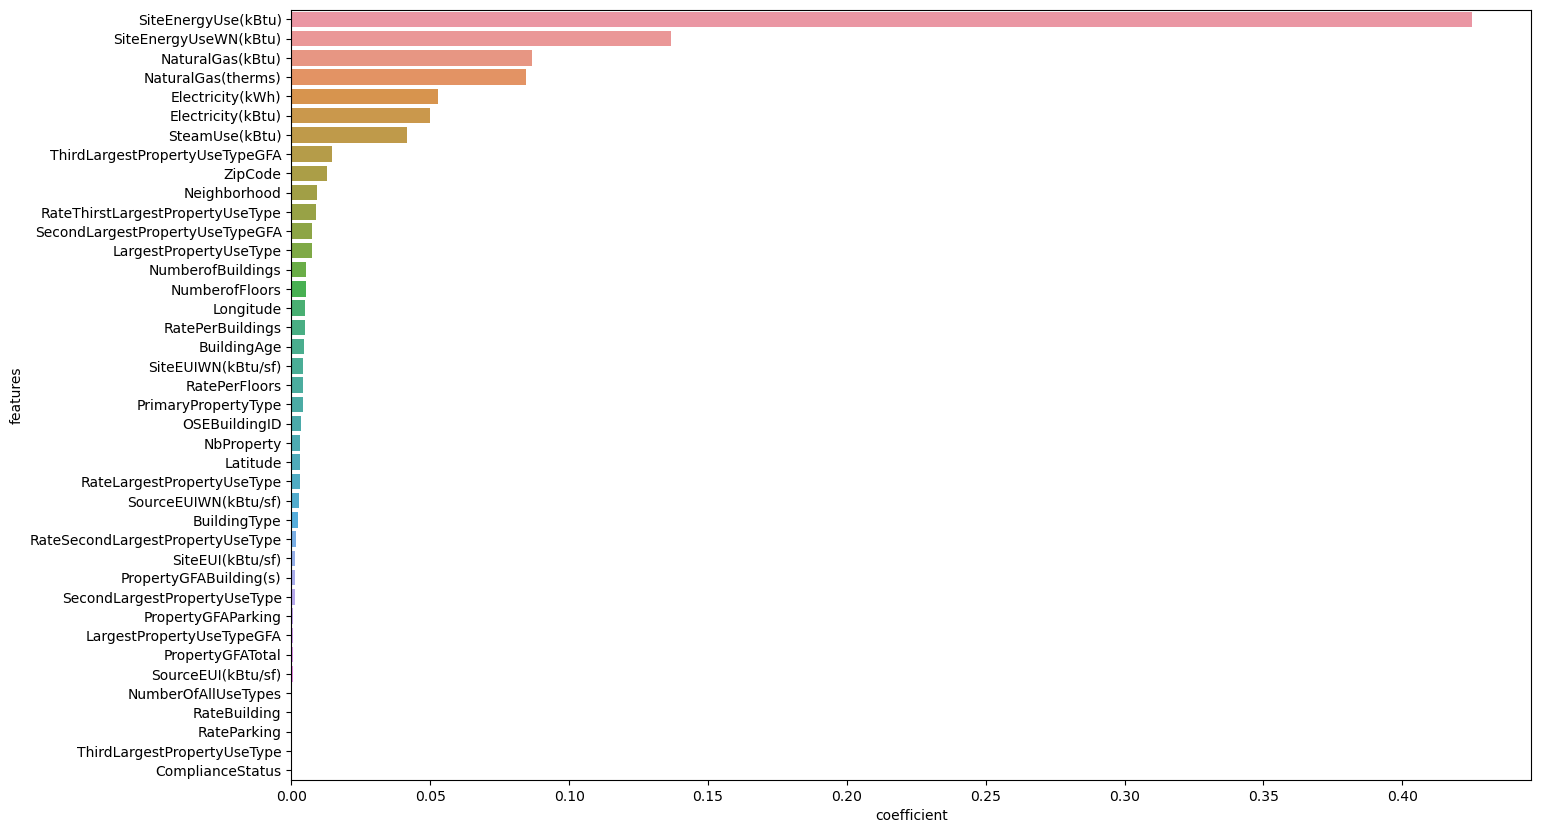

In [59]:
rf_ord_enc = RandomForestRegressor().fit(X_train_prep, y_train)

sc_train, sc_test = get_rmse(rf_ord_enc, name)
rmse_train.append(sc_train)
rmse_test.append(sc_test)
model_names.append('RF ord_enc')


features = pd.DataFrame()
features["features"] = X_train_prep.columns
features["coefficient"] = rf_ord_enc.feature_importances_

features.sort_values(by=["coefficient"], ascending=False, inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(16,10)
sns.barplot(data=features, x="coefficient", y="features")

In [60]:
rf_ord_enc

RandomForestRegressor()

In [61]:
show_results()

,model_names,rmse_train,rmse_test
0,DummyRegressor,495.1,690.2
1,SVR,499.0,694.2
2,DecisionTreeRegressor,0.0,352.9
3,RandomForestRegressor,95.3,337.8
4,AdaBoostRegressor,120.8,298.4
5,LGBMRegressor,239.7,349.7
6,GradientBoostingRegressor,7.4,279.7
7,ExtraTreesRegressor,0.0,333.9
8,RF ord_enc,123.2,345.1


a little better

## Hyperparameter tuning

skops provides a more secure format via the skops.io module. It avoids using pickle and only loads files which have types and references to functions which are trusted either by default or by the user. The API is very similar to pickle. But for now we'll use pickle.

In [71]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    "n_estimators": [80, 100, 120],
    "max_features": [3, 5, None],
    "max_leaf_nodes": [10, 100, 500, None],
    "min_samples_leaf": [5, 10, 20, 50],
}

gridsearch_cv = GridSearchCV(
    RandomForestRegressor(n_jobs=2), param_grid=param_grid,
    scoring="neg_mean_squared_error", n_jobs=3,
    return_train_score=True, refit=True
)
    
def hyperparam_tuning(param_grid, gridsearch_cv):

    gridsearch_cv.fit(X_train_prep, y_train)
    
    print(f"gridsearch_cv best params: \n{gridsearch_cv.best_params_}")
    try:
        pickle.dump(gridsearch_cv.best_estimator_, open("best_gridsearch_cv_model.pickle", "wb"))
        print("Best model saved in pickle.")
    except Exception as e:
        print(f"Error occurs while saving the model: {e}")
        
    cv_results = pd.DataFrame(gridsearch_cv.cv_results_)
    cv_results["mean_test_error"] = -cv_results["mean_test_score"]
    cv_results["mean_train_error"] = -cv_results["mean_train_score"]

    cv_results['rmse_train'] = np.sqrt(cv_results["mean_train_error"])
    cv_results['rmse_validation'] = np.sqrt(cv_results["mean_test_error"])

    columns = [f"param_{name}" for name in param_grid.keys()]
    columns += ['rmse_train', 'rmse_validation']
    display(cv_results[columns].sort_values(by="rmse_validation"))
    
    error = -gridsearch_cv.score(X_test_prep, y_test)
    print(f"Our random forest regressor makes an error of {error**0.5:.2f} on the test set")
    
    
hyperparam_tuning(param_grid, gridsearch_cv)

gridsearch_cv best params: 
{'max_features': None, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'n_estimators': 100}
Best model saved in pickle.


,param_n_estimators,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,rmse_train,rmse_validation
133,100,None,None,5,269.980990,322.459458
108,80,None,100,5,269.760456,323.103696
120,80,None,500,5,270.062742,323.402414
132,80,None,None,5,272.773055,323.707644
98,120,None,10,5,268.376851,324.177810
...,...,...,...,...,...,...
35,120,3,500,50,436.303717,443.171519
22,100,3,100,50,436.239426,443.191685
47,120,3,None,50,435.790449,443.233897
10,100,3,10,50,435.856922,443.379270


Our random forest regressor makes an error of 297.27 on the test set


RandomizedSearchCV

In [21]:
param_distributions = {
    "max_features": [1, 2, 3, 5, None],
    "max_leaf_nodes": [10, 100, 1000, None],
    "min_samples_leaf": [1, 2, 5, 10, 20, 50, 100],
}

search_cv = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=2), param_distributions=param_distributions,
    scoring="neg_mean_squared_error", n_iter=10, random_state=0, n_jobs=2,
    return_train_score=True
)
    
def hyperparam_tuning(param_distributions, search_cv):

    search_cv.fit(X_train_prep, y_train)
    
    print(f"search_cv best params: {search_cv.best_params_}")
    try:
        pickle.dump(search_cv.best_estimator_, open("best_search_cv_model.pickle", "wb"))
        print("Best model saved in pickle.")
    except Exception as e:
        print(f"Error occurs while saving the model: {e}")

    cv_results = pd.DataFrame(search_cv.cv_results_)
    cv_results["mean_test_error"] = -cv_results["mean_test_score"]
    cv_results["mean_train_error"] = -cv_results["mean_train_score"]

    cv_results['rmse_train'] = np.sqrt(cv_results["mean_train_error"])
    cv_results['rmse_validation'] = np.sqrt(cv_results["mean_test_error"])

    columns = [f"param_{name}" for name in param_distributions.keys()]
    columns += ['rmse_train', 'rmse_validation']
    display(cv_results[columns].sort_values(by="rmse_validation"))
    
    error = -search_cv.score(X_test_prep, y_test)
    print(f"Our random forest regressor makes an error of {error**0.5:.2f} on the test set")
    
    
hyperparam_tuning(param_distributions, search_cv)

,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,rmse_train,rmse_validation
4,5,100,2,198.248407,313.478965
3,2,None,2,226.818886,348.418891
2,1,100,1,150.256144,374.905490
9,1,100,2,263.359447,383.073942
8,None,100,10,365.147487,406.041373
1,3,10,10,391.487224,423.089865
0,2,1000,10,400.019650,423.693449
7,None,None,20,421.751254,442.858897
6,None,1000,50,464.313810,474.356851
5,1,None,100,504.685531,506.886084


Our random forest regressor makes an error of 170.58 on the test set


In [22]:
param_distributions = {
    "n_estimators": [10, 20, 50, 70, 100, 150],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": loguniform(0.01, 1),
}

search_cv = RandomizedSearchCV(
    GradientBoostingRegressor(), param_distributions=param_distributions,
    scoring="neg_mean_squared_error", n_iter=20, random_state=0, n_jobs=4,
    return_train_score=True
)

hyperparam_tuning(param_distributions, search_cv)

,param_n_estimators,param_max_leaf_nodes,param_learning_rate,rmse_train,rmse_validation
5,150,5,0.061034,8.582194,328.252103
2,100,10,0.176656,4.551231,330.785851
13,50,50,0.297739,6.790101,331.261919
9,70,20,0.083745,11.727244,341.109363
6,70,50,0.047293,33.339621,344.217635
14,150,50,0.01864,49.036350,345.036663
18,20,5,0.248463,22.882554,346.159072
12,70,20,0.067503,15.842190,347.269481
0,10,100,0.125207,161.280202,356.837442
1,20,20,0.160519,33.148593,373.125800


Our random forest regressor makes an error of 174.58 on the test set


## Prediction intervals

https://www.valencekjell.com/posts/2022-09-14-prediction-intervals/

# Conclusions & explainability
- not enough data especially for tree based ensemble models
- what model overfit or underfit
- tree based models have a fix range of predictions

Load the model if you don't want to re-run all the notebook. (Side note: pickle can also be used to save / use models in production):

In [86]:
# use best_search_cv_model.pickle instead
model = pickle.load(open("./best_gridsearch_cv_model.pickle", 'rb'))
model

RandomForestRegressor(max_features=None, min_samples_leaf=5, n_jobs=2)

In [87]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X_test_prep)

# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test_prep)

Permutation explainer: 672it [04:15,  2.56it/s]                         


https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

In [ ]:
lgb.__version__

In [ ]:
https://www.kaggle.com/code/hmendonca/lightgbm-predictions-explained-with-shap-0-796

In [ ]:
shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x)

In [ ]:
shap.summary_plot(shap_values, valid_x)


In [ ]:
shap.dependence_plot("EXT_SOURCE_2", shap_values, valid_x)
